## Customer-Level EDA
This notebook analyses customer demographics, digital usage, product ownership, and transaction behavior in relation to whether the customer has engaged (`has_engaged`) in any campaign.

In [1]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import eda_functions
importlib.reload(eda_functions)
import eda_functions as eda

In [2]:
# Load datasets
engagement_details = pd.read_csv("../data/processed/engagement_details.csv")
customers = pd.read_csv("../data/processed/customer.csv")
digital_usage = pd.read_csv("../data/processed/digital_usage.csv")
products_owned = pd.read_csv("../data/processed/products_owned.csv")
transactions = pd.read_csv("../data/processed/transactions.csv")

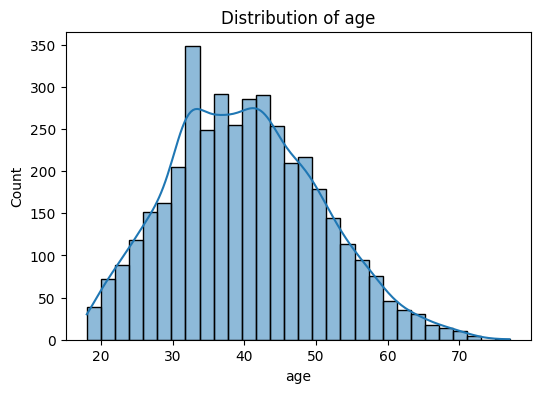

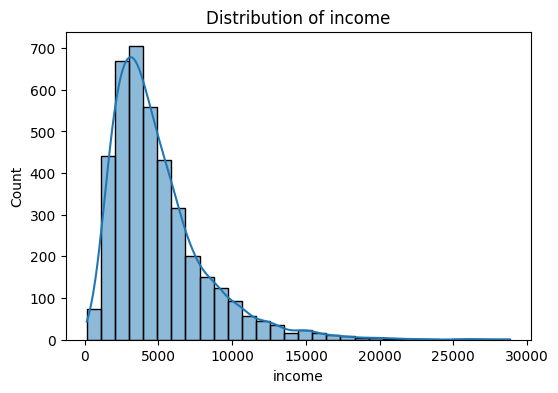

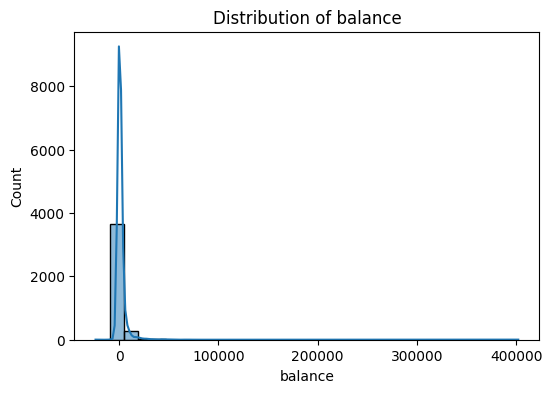

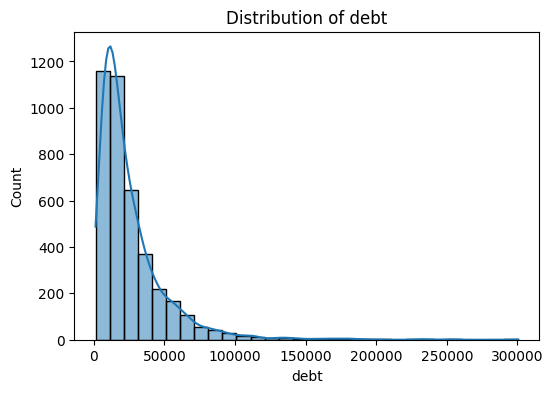

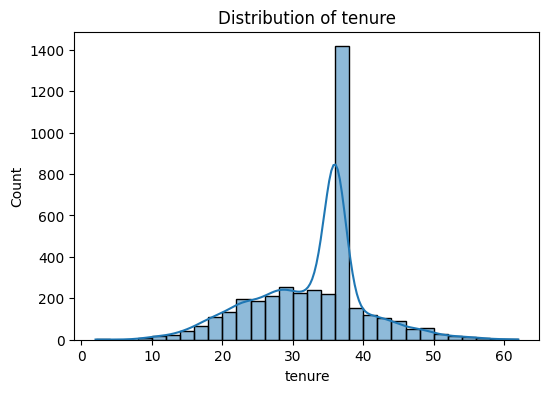

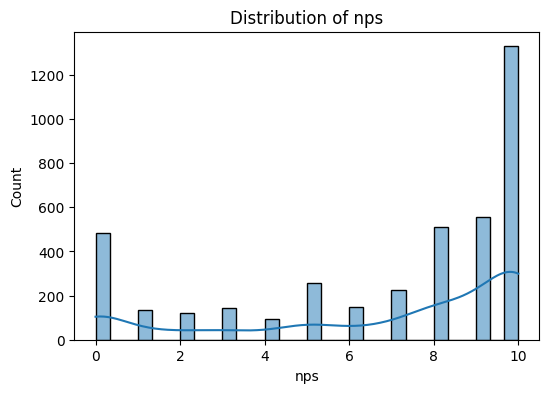

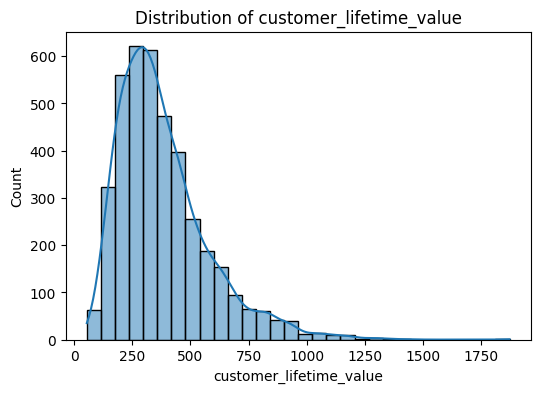

In [3]:
# Univariate EDA for key numeric features in customers
numeric_cols = ['age', 'income', 'balance', 'debt', 'tenure', 'nps', 'customer_lifetime_value']
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(customers[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

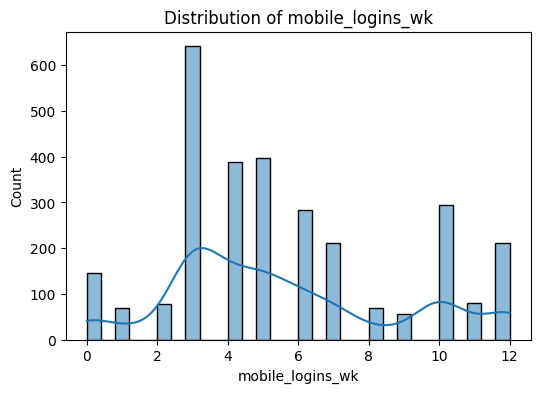

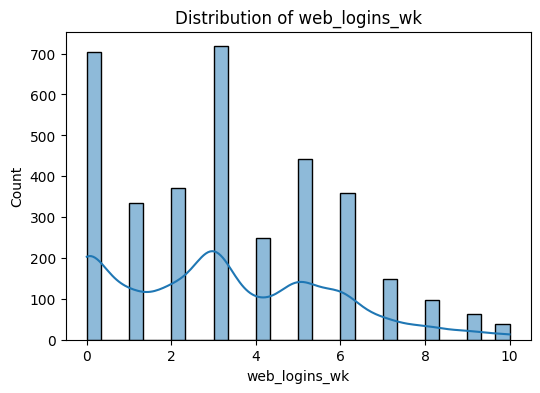

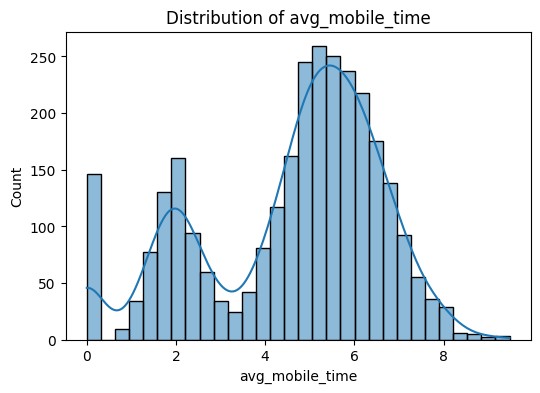

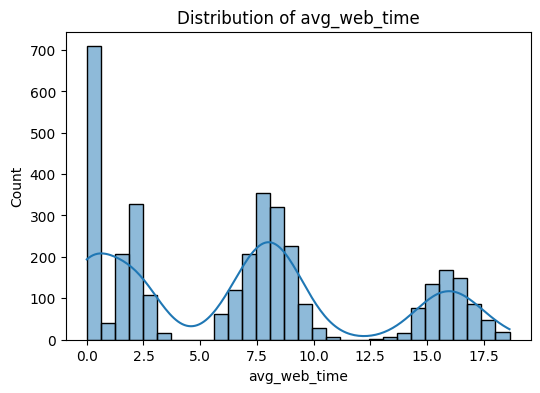

In [4]:
# Digital usage histograms
usage_cols = ['mobile_logins_wk', 'web_logins_wk', 'avg_mobile_time', 'avg_web_time']
for col in usage_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(digital_usage[col].dropna(), bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

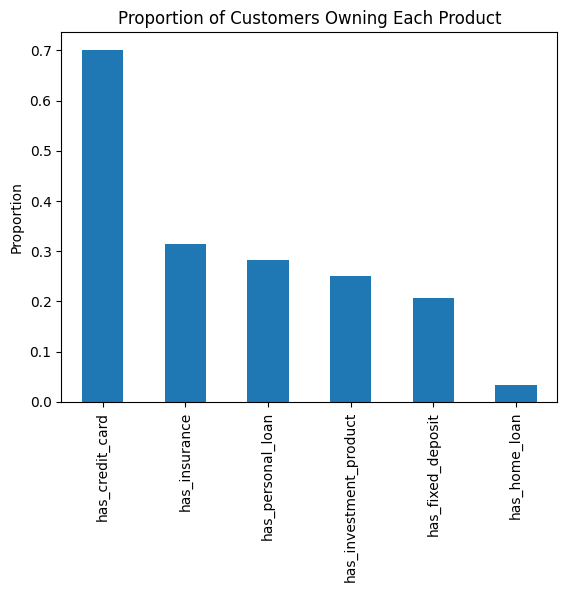

In [5]:
# Product ownership (bar plot per product)
product_cols = [col for col in products_owned.columns if col != 'customer_id']
products_owned[product_cols].mean().sort_values(ascending=False).plot(kind='bar')
plt.title("Proportion of Customers Owning Each Product")
plt.ylabel("Proportion")
plt.show()

In [6]:
# Create customer-level has_engaged flag (1 if engaged in any campaign)
customer_engagement = (
    engagement_details
    .groupby("customer_id")["has_engaged"]
    .max()
    .reset_index()
)

# Check for nulls in 'has_engaged'
null_count = customer_engagement["has_engaged"].isnull().sum()
print(f"Number of nulls in 'has_engaged': {null_count}")

print(f"\nShape of customer_engagement: {customer_engagement.shape}")
print(f"\nFirst few rows of customer_engagement:\n{customer_engagement.head()}")

Number of nulls in 'has_engaged': 0

Shape of customer_engagement: (4000, 2)

First few rows of customer_engagement:
   customer_id  has_engaged
0            1            0
1            2            1
2            3            1
3            4            1
4            5            1


In [7]:
# Aggregate transactions 
transaction_summary = (
    transactions
    .groupby("customer_id")
    .agg(
        total_transaction_amt=("transaction_amt", "sum"),
        transaction_count=("transaction_id", "count"),
        last_transaction_date=("transaction_date", "max")
    )
    .reset_index()
)

# Get percentage of null values in column last_transaction_date
test_df = customer_engagement.merge(transaction_summary, on='customer_id', how='left')
null_percentages_test= test_df.isnull().mean().round(4) * 100
null_percentages_test = null_percentages_test.sort_values(ascending=False)
print(f"Percentage of nulls in transaction columns after merge:\n{null_percentages_test}")

#~54% of customers have never transacted
#This may include inactive, new, or digitally engaged but not monetized customers

Percentage of nulls in transaction columns after merge:
total_transaction_amt    53.67
transaction_count        53.67
last_transaction_date    53.67
customer_id               0.00
has_engaged               0.00
dtype: float64


In [8]:
# Feature engineering on digital usage

# Convert to datetime format
digital_usage['last_mobile_use'] = pd.to_datetime( digital_usage['last_mobile_use'], format="%Y-%m-%d")
digital_usage['last_web_use'] = pd.to_datetime( digital_usage['last_web_use'], format="%Y-%m-%d")
# Convert date fields to days since xxx format
reference_date = pd.to_datetime('2025-01-01')
digital_usage['days_since_mobile_use'] = (reference_date - digital_usage['last_mobile_use']).dt.days
digital_usage['days_since_web_use'] = (reference_date - digital_usage['last_web_use']).dt.days

digital_usage["total_logins_per_week"] = digital_usage[["mobile_logins_wk", "web_logins_wk"]].sum(axis=1)
digital_usage["avg_total_time_per_session"] = digital_usage[["avg_mobile_time", "avg_web_time"]].sum(axis=1)

# Drop original columns
digital_usage = digital_usage.drop(columns=["last_mobile_use", "last_web_use", 
                                               "mobile_logins_wk", "web_logins_wk",
                                               "avg_mobile_time", "avg_web_time"])

print(f"Null counts per column: \n {digital_usage.isnull().sum()}")
print(f"\nShape of digital_usage: {digital_usage.shape}")
print(f"\nFirst few rows of digital_usage:\n{digital_usage.head()}")

Null counts per column: 
 customer_id                      0
has_mobile_app                   0
has_web_account                  0
days_since_mobile_use         1080
days_since_web_use             480
total_logins_per_week            0
avg_total_time_per_session       0
dtype: int64

Shape of digital_usage: (4000, 7)

First few rows of digital_usage:
   customer_id  has_mobile_app  has_web_account  days_since_mobile_use  \
0         1987               1                1                   54.0   
1            2               0                1                    NaN   
2            3               1                1                  529.0   
3            4               1                1                  108.0   
4            5               1                1                   75.0   

   days_since_web_use  total_logins_per_week  avg_total_time_per_session  
0                52.0                    3.0                       22.91  
1               301.0                    6.0        

In [9]:
# Check missing days_since_mobile_use correlation with has_mobile_app
check = eda.check_missing_correlation(digital_usage, "days_since_mobile_use", "has_mobile_app")

# Check missing days_since_web_use correlation with has_web_account
check = eda.check_missing_correlation(digital_usage, "days_since_web_use", "has_web_account")

# Results interpretation: The customers who are missing days_since_mobile_use or days_since_web_use are those who never had access to the respective platforms

# Fill the missing values by assigning a large number to indicate extreme inactivity
digital_usage["days_since_mobile_use"] = digital_usage["days_since_mobile_use"].fillna(999)
digital_usage["days_since_web_use"] = digital_usage["days_since_web_use"].fillna(999)

Total missing values in 'days_since_mobile_use': 1080

Value counts of 'has_mobile_app' where 'days_since_mobile_use' is missing:
has_mobile_app
0    1080
Name: count, dtype: int64
Total missing values in 'days_since_web_use': 480

Value counts of 'has_web_account' where 'days_since_web_use' is missing:
has_web_account
0    480
Name: count, dtype: int64


In [10]:
# Feature engineering on products owned
products_owned["num_products_owned"] = products_owned.drop(columns="customer_id").sum(axis=1)

# Check for nulls in 'num_products_owned'
null_count = products_owned["num_products_owned"].isnull().sum()
print(f"Number of nulls in 'num_products_owned': {null_count}")

print(f"\nShape of products_owned: {products_owned.shape}")
print(f"\nFirst few rows of products_owned:\n{products_owned.head()}")

Number of nulls in 'num_products_owned': 0

Shape of products_owned: (4000, 8)

First few rows of products_owned:
   customer_id  has_investment_product  has_credit_card  has_home_loan  \
0          166                       0                1              1   
1          139                       1                1              0   
2          484                       0                1              0   
3          508                       0                0              0   
4          119                       0                1              0   

   has_personal_loan  has_fixed_deposit  has_insurance  num_products_owned  
0                  0                  0              0                   2  
1                  0                  0              0                   2  
2                  0                  0              0                   1  
3                  0                  1              0                   1  
4                  0                  0              0  

In [11]:
# Merge all features into combined_df
combined_df = (
    customers
    .merge(customer_engagement, on="customer_id", how="left")
    .merge(digital_usage, on="customer_id", how="left")
    .merge(transaction_summary, on="customer_id", how="left")
    .merge(products_owned[["customer_id", "num_products_owned"]], on="customer_id", how="left")
)

In [12]:

# Create high-value user flag based on median thresholds
login_median = combined_df["total_logins_per_week"].median()
spend_median = combined_df["total_transaction_amt"].median()
combined_df["is_high_value_user"] = (
    (combined_df["total_logins_per_week"] > login_median) &
    (combined_df["total_transaction_amt"] > spend_median)
).astype(int)

# Feature: transaction frequency
combined_df["transaction_frequency"] = combined_df["transaction_count"] / combined_df["tenure"]
combined_df[["total_transaction_amt", "transaction_count", "transaction_frequency"]] = combined_df[[
    "total_transaction_amt", "transaction_count", "transaction_frequency"]].fillna(0)

combined_df = combined_df.drop(columns=["last_transaction_date"])


In [13]:
# Check nulls
null_counts = combined_df.isnull().sum()
null_percentages = (combined_df.isnull().mean() * 100).round(2)
null_summary = pd.DataFrame({
    "Null Count": null_counts,
    "Null %": null_percentages}).sort_values("Null %", ascending=False)
print("Null summary:\n", null_summary)

print(f"\nFirst few rows:\n {combined_df.head()}")
print("\nShape of combined_df:", combined_df.shape)

Null summary:
                             Null Count  Null %
avg_total_time_per_session          19    0.47
total_logins_per_week               19    0.47
days_since_web_use                  19    0.47
days_since_mobile_use               19    0.47
has_web_account                     19    0.47
has_mobile_app                      19    0.47
customer_id                          0    0.00
has_engaged                          0    0.00
is_high_value_user                   0    0.00
num_products_owned                   0    0.00
transaction_count                    0    0.00
total_transaction_amt                0    0.00
customer_lifetime_value              0    0.00
age                                  0    0.00
dependents                           0    0.00
nps                                  0    0.00
tenure                               0    0.00
income                               0    0.00
debt                                 0    0.00
balance                              0    0.0

In [14]:
# Drop rows with null values in any column in combined_df
before = combined_df.shape[0]
combined_df = combined_df.dropna()
after = combined_df.shape[0]

print(f"Dropped {before - after} rows with nulls. Remaining rows: {after}")

Dropped 19 rows with nulls. Remaining rows: 4000


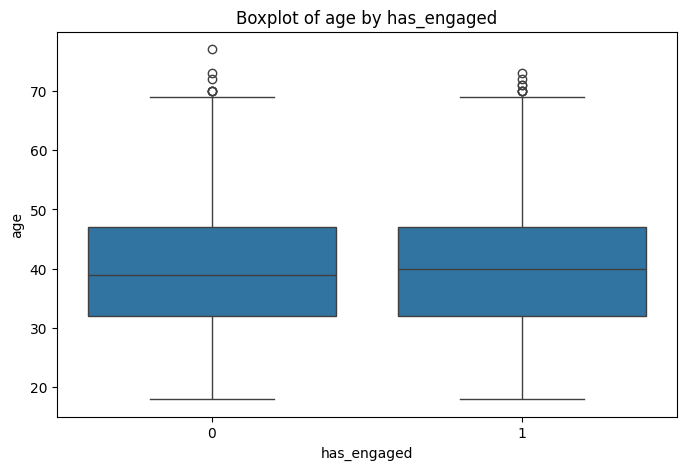

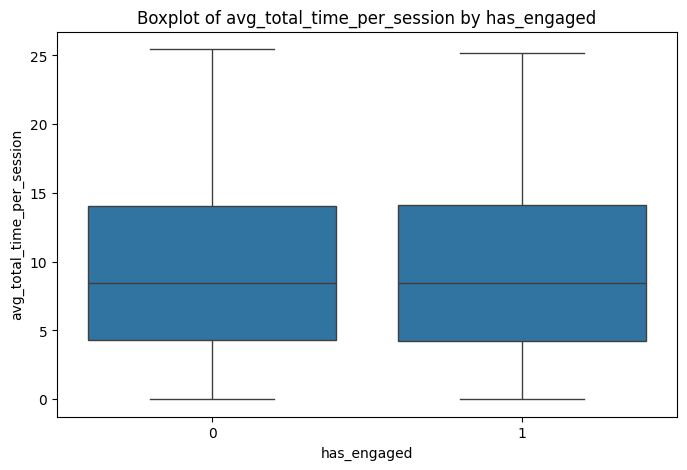

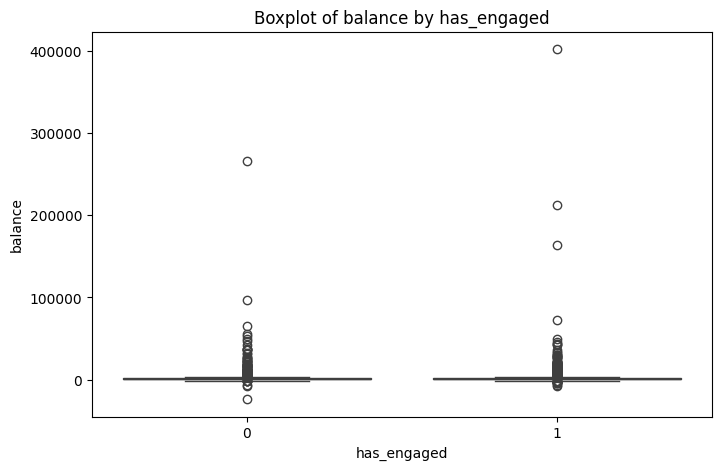

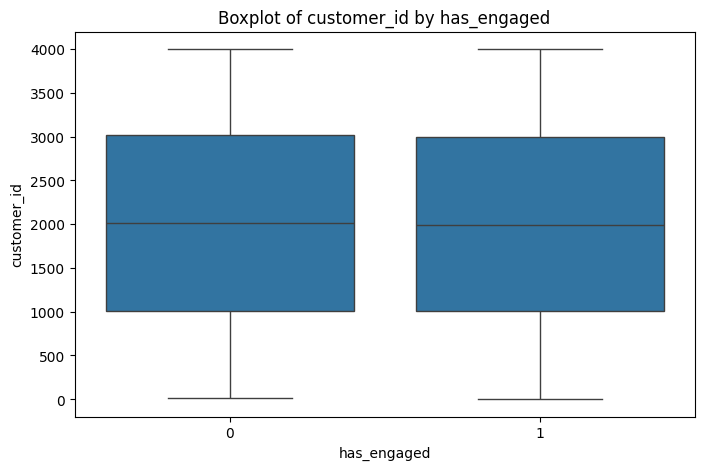

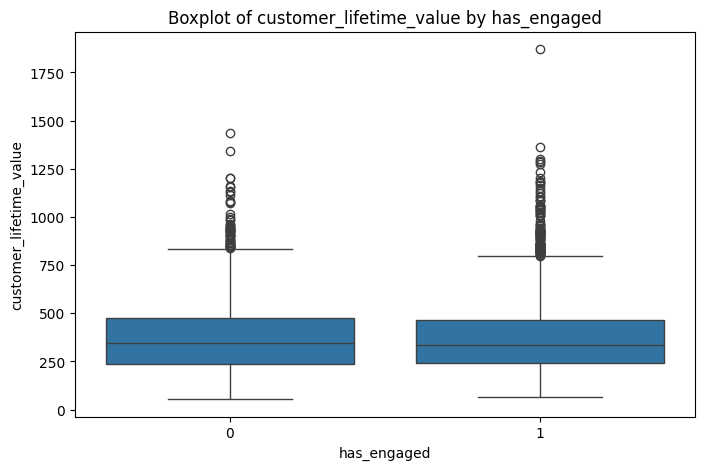

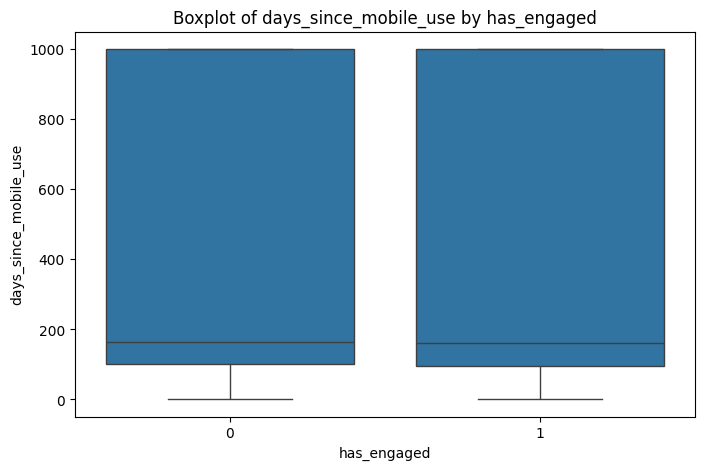

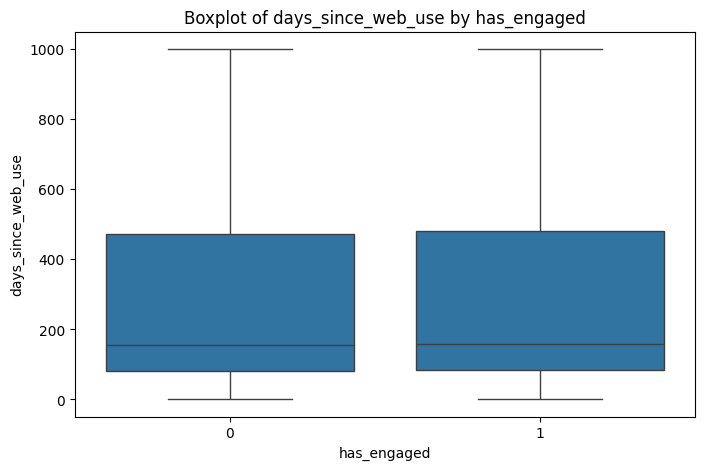

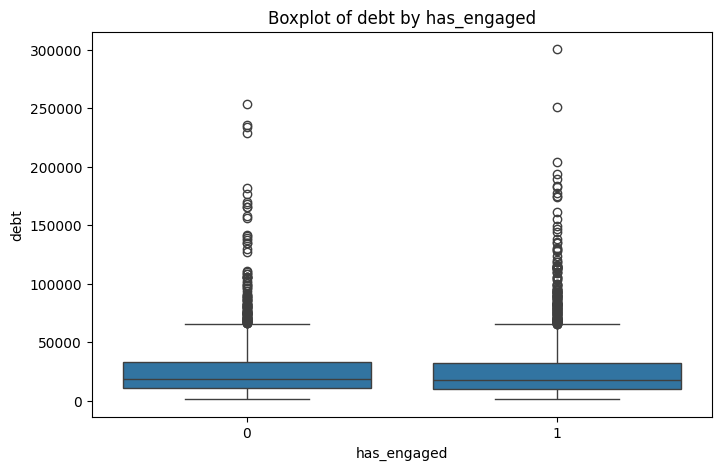

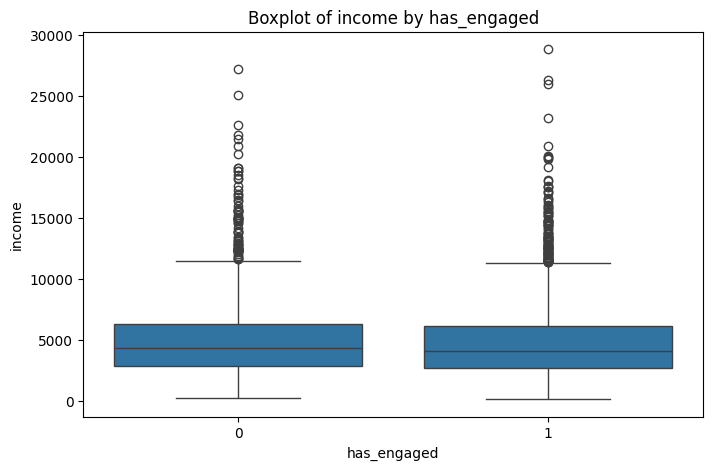

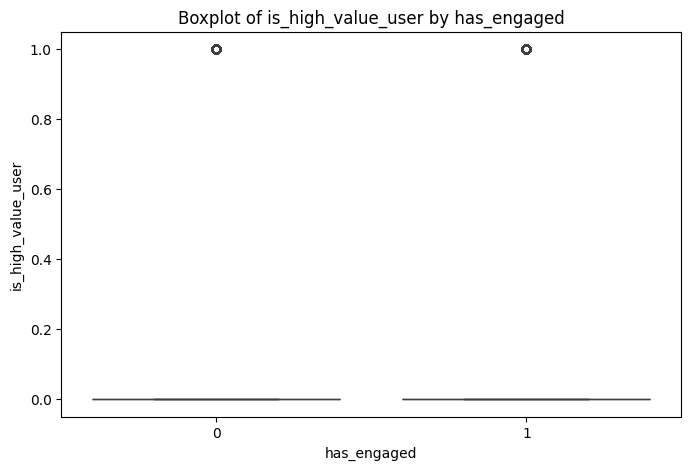

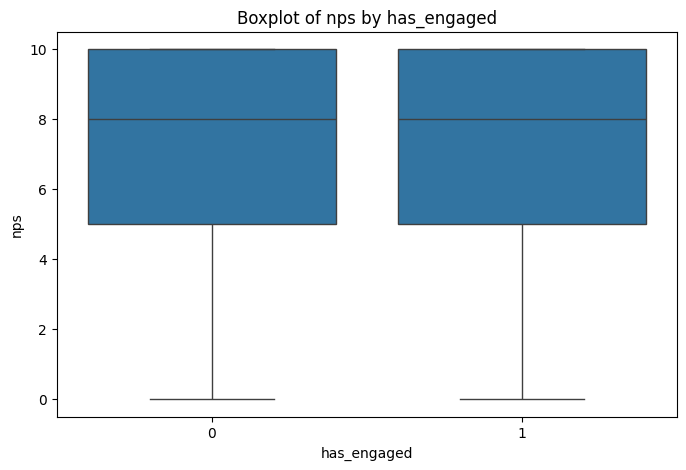

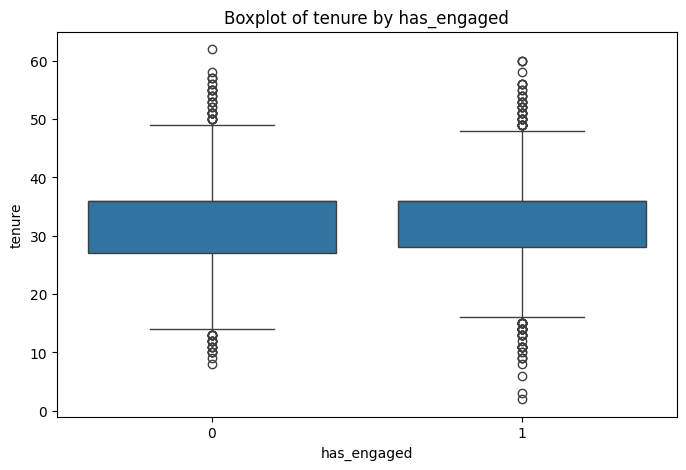

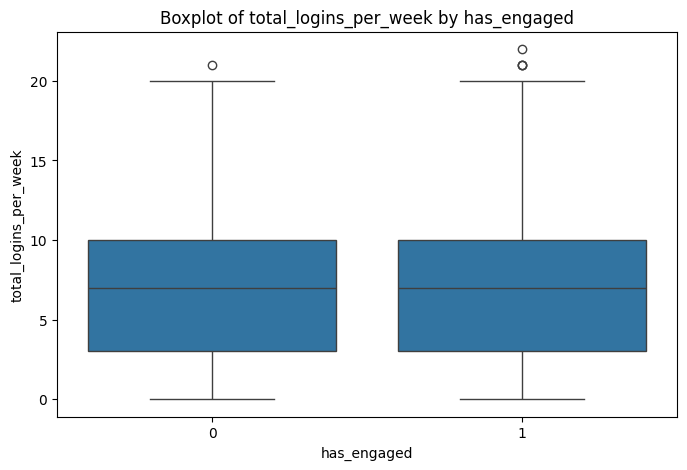

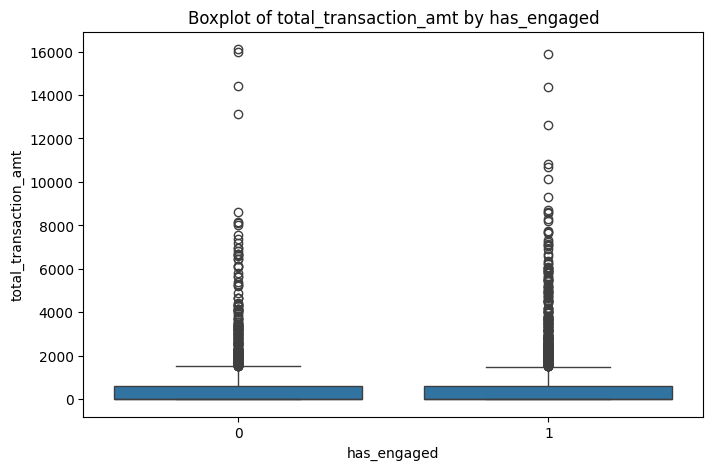

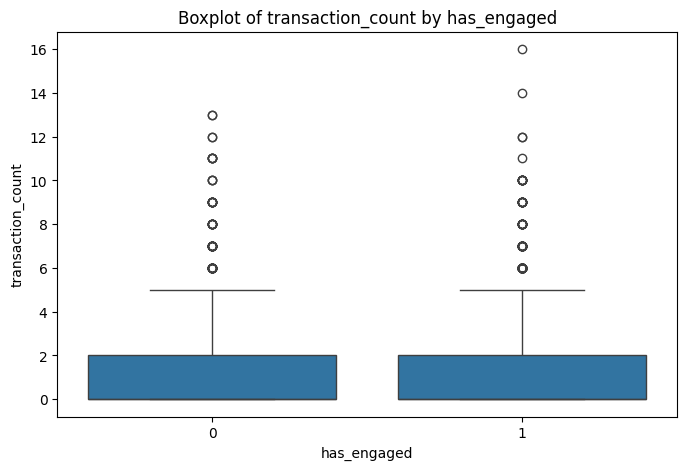

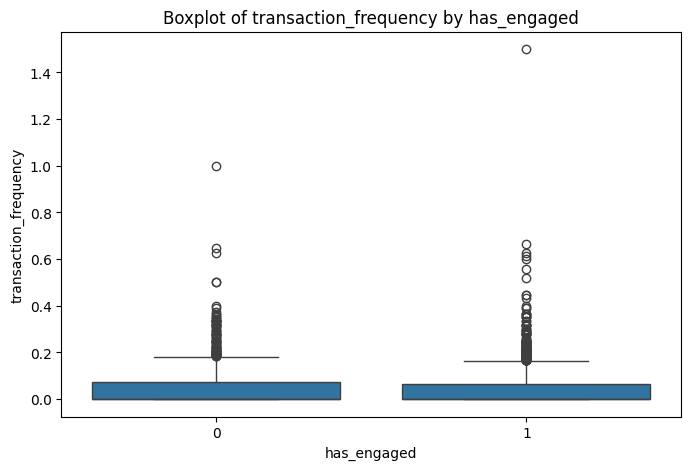

In [15]:
# Set df and target column
df = combined_df.copy()
target_col = 'has_engaged'

# 1. Boxplots for numerical variables by engagement
eda.get_boxplot(df, target_col)

In [16]:
# 2. T-tests for numerical variables
ttest_results = eda.get_ttest(df, target_col)
print("T-test Results:\n", ttest_results)

T-test Results:
                        Feature  T-Statistic   P-Value
8                       income     1.314039  0.188918
14           transaction_count     1.212980  0.225219
15       transaction_frequency     1.050199  0.293697
9           is_high_value_user    -0.737522  0.460853
7                         debt     0.501469  0.616072
3                  customer_id     0.474403  0.635242
10                         nps    -0.325732  0.744647
6           days_since_web_use    -0.308811  0.757484
12       total_logins_per_week    -0.292076  0.770245
4      customer_lifetime_value     0.280930  0.778780
0                          age     0.215197  0.829626
5        days_since_mobile_use     0.168906  0.865880
13       total_transaction_amt     0.132746  0.894402
2                      balance     0.116553  0.907220
11                      tenure     0.106208  0.915423
1   avg_total_time_per_session     0.062079  0.950503


In [ ]:
# Identify categorical columns (excluding the target)
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols += [col for col in df.columns 
             if df[col].dropna().nunique() <= 10 and 
             df[col].dtype in ['int64', 'float64'] and col != target_col]

cat_cols = list(set(cat_cols) - {target_col})


Proportion Table for job:
has_engaged           0         1
job                              
admin.         0.381766  0.618234
blue-collar    0.438953  0.561047
entrepreneur   0.396460  0.603540
housemaid      0.387500  0.612500
management     0.414365  0.585635
retired        0.460000  0.540000
self-employed  0.454988  0.545012
services       0.423977  0.576023
student        0.351515  0.648485
technician     0.429003  0.570997
unemployed     0.308943  0.691057
unknown        0.438073  0.561927


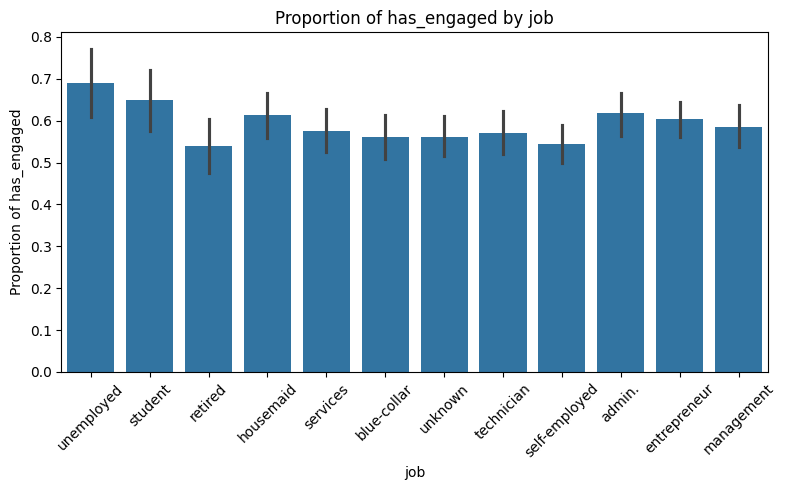


Proportion Table for has_mobile_app:
has_engaged            0         1
has_mobile_app                    
0.0             0.414815  0.585185
1.0             0.414726  0.585274


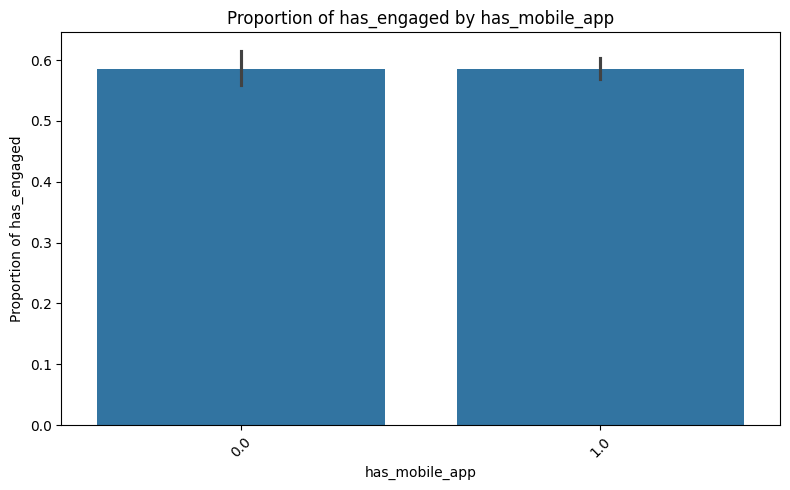


Proportion Table for marital:
has_engaged         0         1
marital                        
divorced     0.446224  0.553776
married      0.416200  0.583800
single       0.400966  0.599034


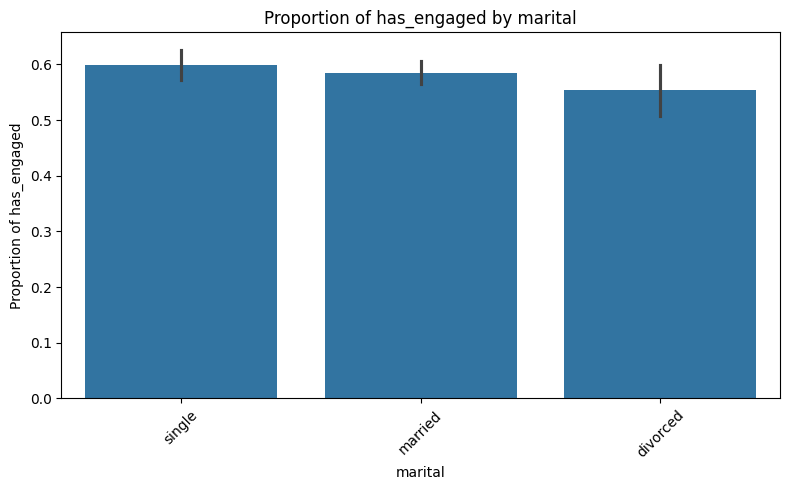


Proportion Table for has_web_account:
has_engaged            0        1
has_web_account                  
0.0              0.43125  0.56875
1.0              0.41250  0.58750


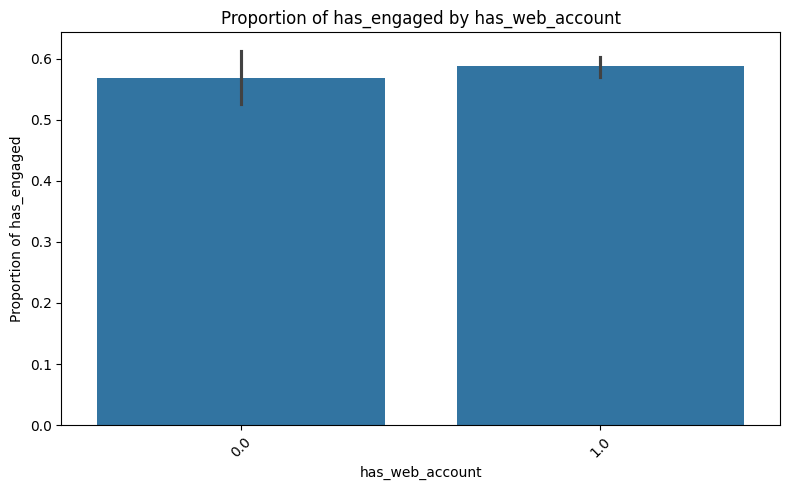


Proportion Table for num_products_owned:
has_engaged                0         1
num_products_owned                    
0                   0.400545  0.599455
1                   0.438335  0.561665
2                   0.402985  0.597015
3                   0.406417  0.593583
4                   0.391813  0.608187
5                   0.470588  0.529412


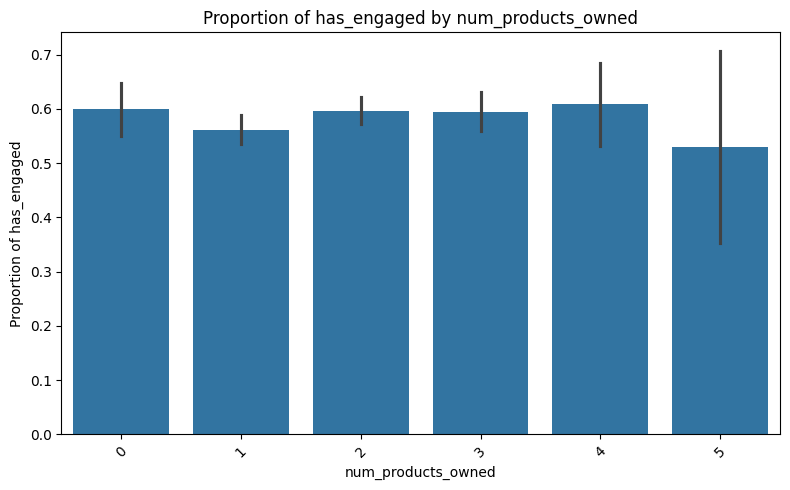


Proportion Table for education:
has_engaged         0         1
education                      
primary      0.380488  0.619512
secondary    0.415392  0.584608
tertiary     0.425801  0.574199
unknown      0.453488  0.546512


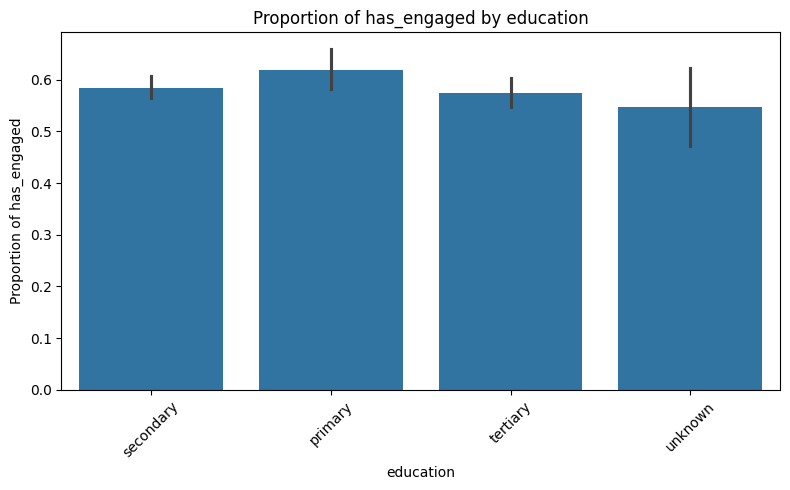


Proportion Table for dependents:
has_engaged         0         1
dependents                     
0            0.364583  0.635417
1            0.431111  0.568889
2            0.416899  0.583101
3            0.404473  0.595527
4            0.445151  0.554849
5            0.401235  0.598765


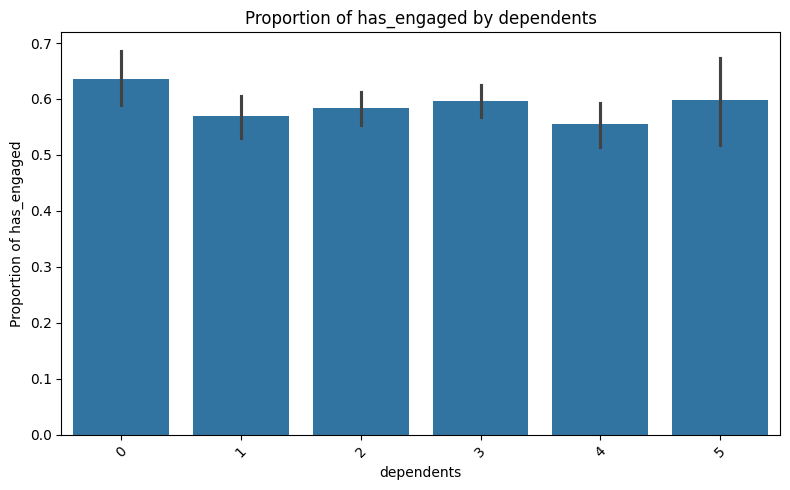


Proportion Table for default:
has_engaged         0         1
default                        
0            0.418279  0.581721
1            0.396256  0.603744


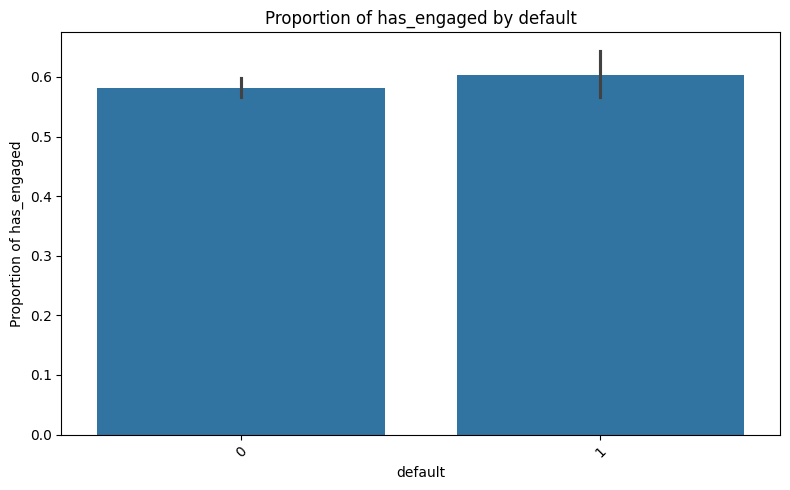

In [ ]:
# 3. Proportion tables & bar plots
for col in cat_cols:
    print(f"\nProportion Table for {col}:")
    print(eda.get_proportion_table(df, col, target_col))
    
    eda.get_barplot(df, col, target_col)

In [ ]:
# 4. Chi-square test results
chi2_results = eda.get_chi_square(df, cat_cols, target_col)
print("\nChi-Square Test Results:\n", chi2_results)


Chi-Square Test Results:
               Feature  Chi-Square   P-Value
0                 job   18.776619  0.065223
6          dependents    7.729980  0.171758
5           education    4.637770  0.200326
2             marital    2.775715  0.249609
7             default    0.986778  0.320531
4  num_products_owned    5.045896  0.410305
3     has_web_account    0.536977  0.463688
1      has_mobile_app    0.000000  1.000000
